In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
import scipy
%matplotlib inline
from scipy.signal import butter, sosfilt, sosfreqz, iirnotch, freqz, lfilter, filtfilt
import warnings
from pyampd.ampd import find_peaks, find_peaks_original, find_peaks_adaptive
import pywt
warnings.filterwarnings('ignore')

/Users/vishnumurthy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/vishnumurthy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/vishnumurthy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def moving_average(values, x, frame):
    ma_size = values.shape[0]-frame+1
    ma_values = np.ndarray(shape=(ma_size,))
    ma_x = np.ndarray(shape=(ma_size,))
    for i in range(ma_size):
        ma_values[i] = np.average(values[i:i+frame])
        if frame%2==1:
            ma_x[i] = x[(2*i+frame)//2]
        else:
            ma_x[i] = x[(2*i+frame)//2]-1/24
    return ma_values, ma_x

In [3]:
def savitzky_golay(values, frame, degree):
    half_window = frame // 2
    
    coefficients = np.ndarray(shape = (frame, degree+1))
    for counter, k in enumerate(range(-half_window, half_window+1)):
        for i in range(degree+1):
            coefficients[counter][i] = k**i
    coefficients = np.mat(coefficients)
    
    convol = np.linalg.pinv(coefficients).A[0]
    
    firstvals = values[half_window:0:-1]
    lastvals = values[-1:-half_window-1:-1]
    values = np.concatenate((firstvals, values, lastvals))
    
    sg_values = np.convolve(convol, values, mode='valid')
    return sg_values

In [4]:
df = pd.read_csv("../data/blink/OpenBCI-RAW-2019-01-22_17-14-05.txt", header=None).iloc[1:]

2667 2667


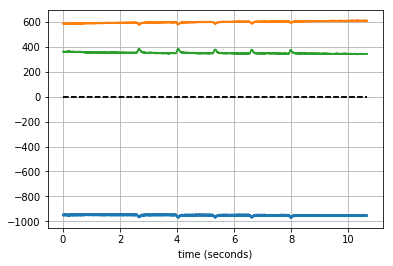

In [5]:
fs = 250.0
f0 = 60.0
lowcut = 1.0
highcut = 50.0
a = 0.02
Q = 30.0
w0 = f0/(fs/2)

t = np.linspace(0, df.shape[0]/fs, df.shape[0], endpoint=False)
plt.figure(2)

y1 = butter_bandpass_filter(df[[1]], lowcut, highcut, fs, order=4)
plt.plot(t, y1, label='Channel 1 Signal')
y4 = butter_bandpass_filter(df[[4]], lowcut, highcut, fs, order=4)
plt.plot(t, y4, label='Channel 4 Signal')
y = abs(y1+y4)
plt.plot(t, y, label='Combined Signal')

plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, df.shape[0]/fs, linestyles='--')
plt.grid(True)
plt.axis('tight')
#plt.legend(loc='upper left')

print(len(t),len(y))

plt.show()

[   1    5    9   13   17   21   30   34   38   42   47   51   55   59
   63   67   72   76   80   84   88   92   97  101  105  109  113  130
  134  138  151  155  656  660  664  668  672  677  681  685  689  999
 1003 1007 1011 1014 1019 1023 1027 1324 1328 1332 1336 1340 1344 1348
 1645 1649 1653 1657 1661 1666 1988 1992 1996 2000 2004 2008 2436 2440
 2565 2569 2574 2578 2582 2586 2590 2636 2640 2657]


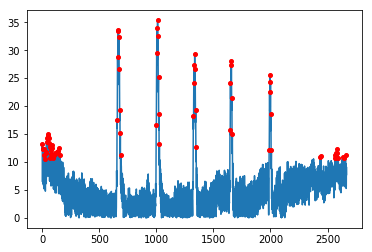

In [15]:
y_2 = y - np.mean(y)
x_fourier = np.arange(df.shape[0])
y_fourier = np.fft.rfft(y_2).flatten()

# identify the peaks of the transform (use peakutils.peak.indexes()) and confirm that these are reasonable peaks for the transform
peaks = peakutils.peak.indexes(np.abs(y_fourier))
print(peaks)
plt.plot(x_fourier, np.abs(y_fourier))

plt.plot([x_fourier[x] for x in peaks], [np.abs(y_fourier[x]) for x in peaks], 'ro', markersize=4)

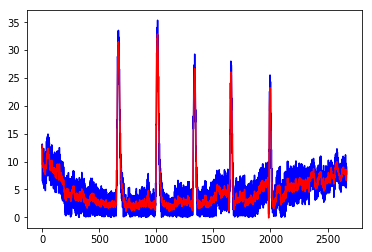

In [7]:
plt.plot(x_fourier, np.abs(y_fourier), 'b')

filtered_y_fourier = savitzky_golay(np.abs(y_fourier), 7, 2)
plt.plot(x_fourier, filtered_y_fourier, 'r')
#plt.plot(dates, savgol_filter(values, 7, 2), 'g')
plt.show()

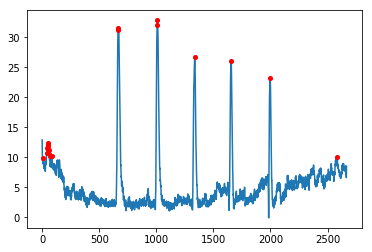

In [18]:
peaks = peakutils.peak.indexes(filtered_y_fourier)
plt.plot(x_fourier, filtered_y_fourier)
plt.plot([x_fourier[x] for x in peaks], [np.abs(filtered_y_fourier[x]) for x in peaks], 'ro', markersize=4)

Text(0,0.5,'signal')

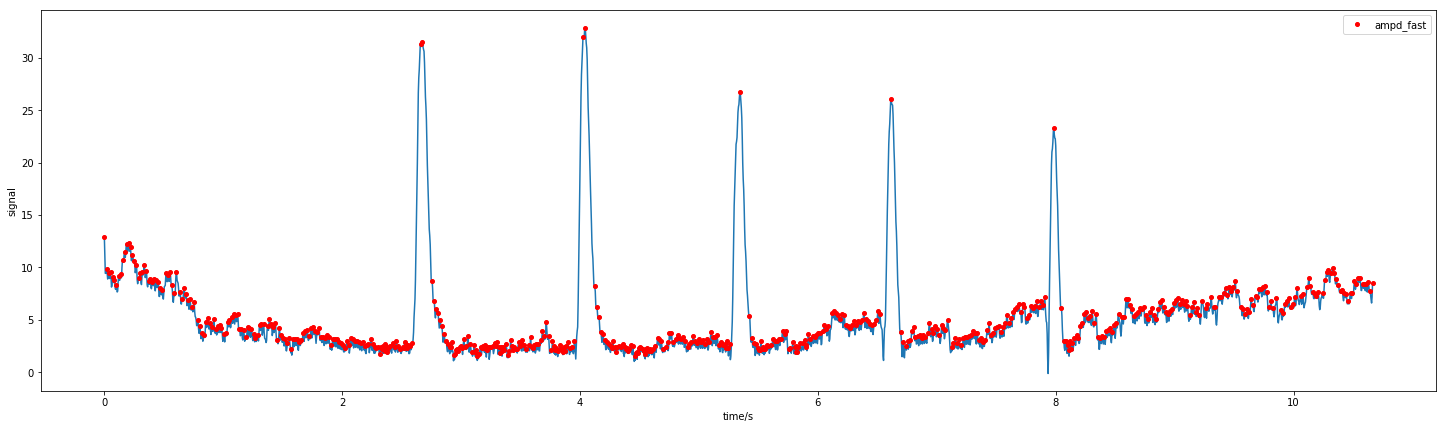

In [20]:
#######Considered AMPD peak detection on y data through savitzky_golay
methods = [
    #('original_ampd', find_peaks_original),
    #('ampd', find_peaks),
    ('ampd_fast', lambda x: find_peaks(x, scale=50)),
    #('ass_ampd', find_peaks_adaptive),
]
all_pks = [method(filtered_y_fourier) for name, method in methods]

plt.figure(figsize=(25, 7))
plt.plot(t, filtered_y_fourier, '-')
for idx in range(len(methods)):
    pks = all_pks[idx]
    offset = idx * 0.2
    name = methods[idx][0]
    plt.plot(t[pks], offset + filtered_y_fourier[pks], 'ro', markersize=4, label=name)
plt.legend()
plt.xlabel('time/s')
plt.ylabel('signal')

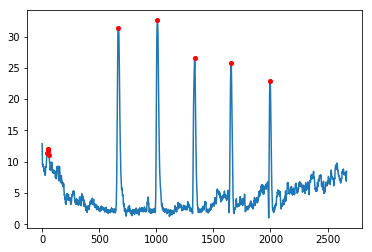

In [23]:
filtered2_y_fourier, x = moving_average(filtered_y_fourier, x_fourier, 3)

filtered2_y_fourier = np.append(filtered2_y_fourier, filtered_y_fourier[-1])
filtered2_y_fourier = np.insert(filtered2_y_fourier, 0, filtered_y_fourier[0])

peaks = peakutils.peak.indexes(filtered2_y_fourier)
plt.plot(x_fourier, filtered2_y_fourier)
plt.plot([x_fourier[x] for x in peaks], [np.abs(filtered2_y_fourier[x]) for x in peaks], 'ro', markersize=4)